In [1]:
import pandas as pd
import os
import json
import numpy as np


def fileter_method(must_item: list, method):
        method_name = method
        for item in must_item:
            if item not in method:
                return False, None
            if "L=" in item or 'Balu_plus' in item:
                item = item 
            else:
                item = "_"+item
            method_name = method_name.replace(item, "")
        return True, method_name

def collect_data_p_balu(p: str, datasets=[], result_dir='results', train_test_flag="test"):
    if not datasets:
        datasets = [d for d in os.listdir(result_dir) if os.path.isdir(os.path.join(result_dir, d))]
    
    for dataset in datasets:
        dataset_dir = os.path.join(result_dir, dataset)
        method_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
        break
    

    method_dirs = [e for e in method_dirs if 'Balu' in e]

    data_rows = []
    for method in method_dirs:
        flag, method_name = fileter_method(['Balu_plus_imp=', 'L=64-64_K=64', "gconv=GCN_rconv=GCN", "reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001"], method)
        if not flag:
            continue
        if "-64" in method_name:
            continue
        if "BaLu" not in method_name:
            continue 
        # if "BaLu_GRAPE_gconv" not in method_name and "BaLu_IGMC_gconv" not in method_name:
        #     continue
        
        # Collect results for each dataset
        for dataset in datasets:
            dataset_dir = os.path.join(result_dir, dataset)
            
            if not os.path.exists(dataset_dir):
                print(f"{dataset_dir} not exits!")
                continue
                
            method_dir = os.path.join(dataset_dir, method)
            if not os.path.exists(method_dir):
                print(f"{method_dir} not exits!")
                continue

            imputation_dir = method_dir
            results_files = [f for f in os.listdir(imputation_dir) 
                        if f.startswith(f"p={p}_") and f.endswith(f"_{train_test_flag}_results.json")]
            # results_files=results_files[:len(results_files)*1.5//2]

            for file in results_files:
                file_path = os.path.join(method_dir, file) # imputation, file)
                try:
                    row = {
                        'Method': method,
                        # 'imputation': imputation
                    }
                    row['Dataset'] = dataset
                    with open(file_path, 'r') as f:
                        results = json.load(f)
                        if 'effect_pehe' in results:
                            row[f"PEHE"] = results['effect_pehe']
                            # effect_pehe_values.append(results['effect_pehe'])
                        if 'effect_mae' in results:
                            row['MAE'] = results['effect_mae']
                            # effect_mae_values.append(results['effect_mae'])
                except (json.JSONDecodeError, FileNotFoundError) as e:
                    print(f"Warning: Error reading file {file_path}: {e}")
                data_rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Sort the DataFrame by method and imputation
    if not df.empty:
        df = df.sort_values(by=['Method']) #, 'imputation'])
    return df


def collect_data_p_others(p: str, datasets=[], result_dir='results', train_test_flag="test"):
    if not datasets:
        # If no datasets are specified, get all available datasets from the directory
        datasets = [d for d in os.listdir(result_dir) if os.path.isdir(os.path.join(result_dir, d))]
    
    # Initialize an empty list to store data rows
    data_rows = []
    
    # First pass: collect all methods and imputations across all datasets
    all_method_imputation_pairs = []
    print(datasets)
    for dataset in datasets:
        dataset_dir = os.path.join(result_dir, dataset)
        if not os.path.exists(dataset_dir):
            print(f"Warning: Dataset directory {dataset_dir} not found. Skipping.")
            continue
            
        # Get all method directories for this dataset
        method_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
        
        method_dirs = [e for e in method_dirs if 'Balu' not in e]

        for method in method_dirs:
            if method == 'rml':
                continue
            method_dir = os.path.join(dataset_dir, method)
            # print(method_dir)
            # print(os.listdir(method_dir))
            for imputation in os.listdir(method_dir):
                
                if p == '0.0' and imputation != 'full':                 # if the missing percentage is 0.0, no evaluation need for other imputation methods
                    continue
                if p != '0.0' and imputation == 'full':                 # if has missing data, there is no evaluation for complete data (full)
                    continue
                # if train_test_flag == "test" and imputation == 'no':    # unimputed units cannot be test with NetDeconf and SPNet
                #     continue
                if imputation not in ['no', 'full']:
                    continue
                
                method_imputation_pair = (method, imputation)
                if method_imputation_pair not in all_method_imputation_pairs:
                    all_method_imputation_pairs.append(method_imputation_pair)
    
    # Second pass: collect results for each method/imputation pair across all datasets
    for method, imputation in all_method_imputation_pairs:
        for dataset in datasets:
            
            dataset_dir = os.path.join(result_dir, dataset)
            if not os.path.exists(dataset_dir):
                print(f"{method_dir} not exits!")
                continue
                
            method_dir = os.path.join(dataset_dir, method)
            if not os.path.exists(method_dir):
                print(f"{method_dir} not exits!")
                continue
            
            imputation_dir = os.path.join(method_dir, imputation)
            
            results_files = [f for f in os.listdir(imputation_dir) 
                        if f.startswith(f"p={p}") and f.endswith(f"{train_test_flag}_results.json")]
            
            
            # Collect metrics from all matching files
            for file in results_files:
                file_path = os.path.join(method_dir, imputation, file)
                try:
                    row = {
                        'Method': method,
                        # 'imputation': imputation
                    }
                    row['Dataset'] = dataset
                    filter_th = 40
                    with open(file_path, 'r') as f:
                        results = json.load(f)
                        # if results['effect_pehe'] == np.nan or results['effect_pehe'] > filter_th: continue
                        if 'Syn_M=' in dataset and results['effect_pehe'] > 25: continue 
                        
                        # if results['effect_mae'] == np.nan or results['effect_mae'] > filter_th: continue
                        if 'effect_pehe' in results:
                            row[f"PEHE"] = results['effect_pehe']
                        if 'effect_mae' in results:
                            row['MAE'] = results['effect_mae']
                except (json.JSONDecodeError, FileNotFoundError) as e:
                    print(f"Warning: Error reading file {file_path}: {e}")
            
                data_rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Sort the DataFrame by method and imputation
    if not df.empty:
        df = df.sort_values(by=['Method'])
    
    return df

def display_dataframe_info(df):
    """
    Display useful information about the dataframe
    """
    print("=== Example DataFrame Information ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nUnique Methods: {df['Method'].unique()}")
    print(f"Unique Datasets: {df['Dataset'].unique()}")
    
    print(f"\nData points per Method-Dataset combination:")
    combination_counts = df.groupby(['Method', 'Dataset']).size()
    print(combination_counts.head(10))
    
    print(f"\nMAE Statistics:")
    print(df['MAE'].describe())
    
    print(f"\nPEHE Statistics:")
    print(df['PEHE'].describe())
    
    print(f"\nMissing Values:")
    print(f"MAE: {df['MAE'].isna().sum()} missing")
    print(f"PEHE: {df['PEHE'].isna().sum()} missing")
    
    print(f"\nFirst 10 rows:")
    print(df.head(10))



# orignal dataset

In [2]:
def create_grouped_boxplot(df, save_fn, figsize=None, palette_name='PonyoMedium'):
    """
    Create separate subplots for each dataset arranged in rows, with PEHE in first row and MAE in second row
    
    Parameters:
    df: pandas DataFrame with columns 'Method', 'Dataset', 'MAE', 'PEHE'
    figsize: tuple, figure size (width, height). If None, auto-calculated based on number of datasets
    palette_name: str, Ghibli palette name (e.g., 'PonyoMedium', 'LaputaMedium', 'SpiritedMedium')
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    custom_colors = [
        '#E74C3C',  # Strong red
        '#FF6F00',  # Vivid orange
        '#F1C40F',  # Bright yellow
        '#388E3C',  # Forest green
        '#3498DB',  # Clear blue
        '#9B59B6',  # Rich purple
        '#E91E63',  # Magenta
        '#1ABC9C',  # Turquoise
        '#95A5A6',  # Silver
        '#607D8B'   # Blue gray
    ]
    
    # Filter out rows where both metrics are NaN
    df_filtered = df.dropna(subset=['PEHE', 'MAE'], how='all')
    
    if df_filtered.empty:
        print("No data available for PEHE or MAE metrics")
        return
    
    # Sort data
    df_filtered = df_filtered.sort_values(['Dataset', 'Method'], ascending=[False, True])
    
    # Define specific method order
    method_order = ['BaLu', 'BaLu(-edge)', 'GCN-HSIC', 'SAGE-HSIC', 'NetDeconf', 'SPNet', 
                   'CausalForest', 'R-Learner', 'T-Learner', 'X-Learner']
    
    # Define specific dataset order
    dataset_order = ['Instagram', 'Youtube', 'BlogCatalog', 'Flickr']
    
    # Get datasets and methods in specified order, filtered to only include those in the data
    available_datasets = [dataset for dataset in dataset_order if dataset in df_filtered['Dataset'].unique()]
    available_methods = [method for method in method_order if method in df_filtered['Method'].unique()]
    n_datasets = len(available_datasets)
    
    # Auto-calculate figure size if not provided
    if figsize is None:
        width = max(4 * n_datasets, 12)  # At least 4 inches per subplot, minimum 12
        height = 6  # Increased height for 2 rows
        figsize = (width, height)
    
    # Set style for better aesthetics
    plt.style.use('default')
    fig, axes = plt.subplots(2, n_datasets, figsize=figsize, sharey=False)  # 2 rows for PEHE and MAE
    
    # Handle case where there's only one dataset (axes won't be a 2D array)
    if n_datasets == 1:
        axes = axes.reshape(2, 1)
    
    # Define metrics for the two rows
    metrics = ['PEHE', 'MAE']
    
    # Create subplots for each metric and dataset
    for row, metric in enumerate(metrics):
        for col, dataset in enumerate(available_datasets):
            ax = axes[row, col]
            
            # Filter data for current dataset and remove NaN for current metric
            dataset_data = df_filtered[df_filtered['Dataset'] == dataset].dropna(subset=[metric])
            
            if dataset_data.empty:
                # If no data, hide the subplot
                ax.set_visible(False)
                continue
            
            # Create box plot for this dataset with methods as hue
            box_plot = sns.boxplot(
                data=dataset_data, 
                x='Method', 
                y=metric, 
                hue='Method',
                order=available_methods,
                hue_order=available_methods,
                ax=ax, 
                palette=custom_colors,
                legend=False
            )
            
            # Set transparency on the box plot artists
            for patch in ax.artists:
                patch.set_alpha(0.8)
            
            # Customize each subplot
            if row == 0:  # First row - add dataset title
                ax.set_title(dataset, fontsize=22, fontweight='bold', pad=15)
            else:  # Second row - no title
                ax.set_title('')
            
            # Remove x-axis labels and ticks
            ax.set_xlabel('')
            ax.set_xticks([])
            
            # Set y-label only for the first column
            if col == 0:
                ax.set_ylabel(metric, fontsize=25, fontweight='medium', color='#2F4F4F')
            else:
                ax.set_ylabel('')
            
            # Style the axes
            ax.tick_params(axis='y', labelsize=18, colors='#2F4F4F')
            
            # Add elegant background
            ax.set_facecolor('#FFFEF7')  # Cream background
            
            # Add subtle grid
            ax.grid(True, alpha=0.3, axis='y', linestyle='--', color='#8FBC8F')
            
            # Remove individual legends (we'll add a single legend at the bottom)
            if ax.get_legend() is not None:
                ax.legend().set_visible(False)
    
    # Adjust layout to prevent overlap
    
    
    # Create a custom legend for all methods in one row
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=custom_colors[i % len(custom_colors)], 
                            alpha=0.8, label=method) 
                      for i, method in enumerate(available_methods)]
    
    legend = fig.legend(handles=legend_elements, bbox_to_anchor=(0.522, 0.035), loc='upper center', 
              fontsize=21.2, frameon=True, shadow=True, fancybox=True, ncol=len(available_methods)//2)
    legend.get_frame().set_facecolor('#FFFEF7')  # Cream background
    legend.get_frame().set_alpha(0.8)
    plt.subplots_adjust(bottom=0.15)  # Make room for legend
    plt.subplots_adjust(bottom=0.12)  # Make room for legend
    plt.tight_layout()
    # Save and show the plot
    plt.savefig(save_fn, bbox_inches='tight', dpi=300)
    plt.show()

['Syn_M=None_SimRel=1_Rel=4_MCAR', 'Youtube_M=20_SimRel=1_Rel=4_MCAR', 'BlogCatalog1_M=20_SimRel=0_Rel=1_MCAR', 'Flickr1_M=20_SimRel=0_Rel=1_MCAR']
['BaLu', 'BaLu(-edge)', 'GCN-HSIC', 'SAGE-HSIC', 'NetDeconf', 'SPNet', 'CausalForest', 'R-Learner', 'T-Learner', 'X-Learner']


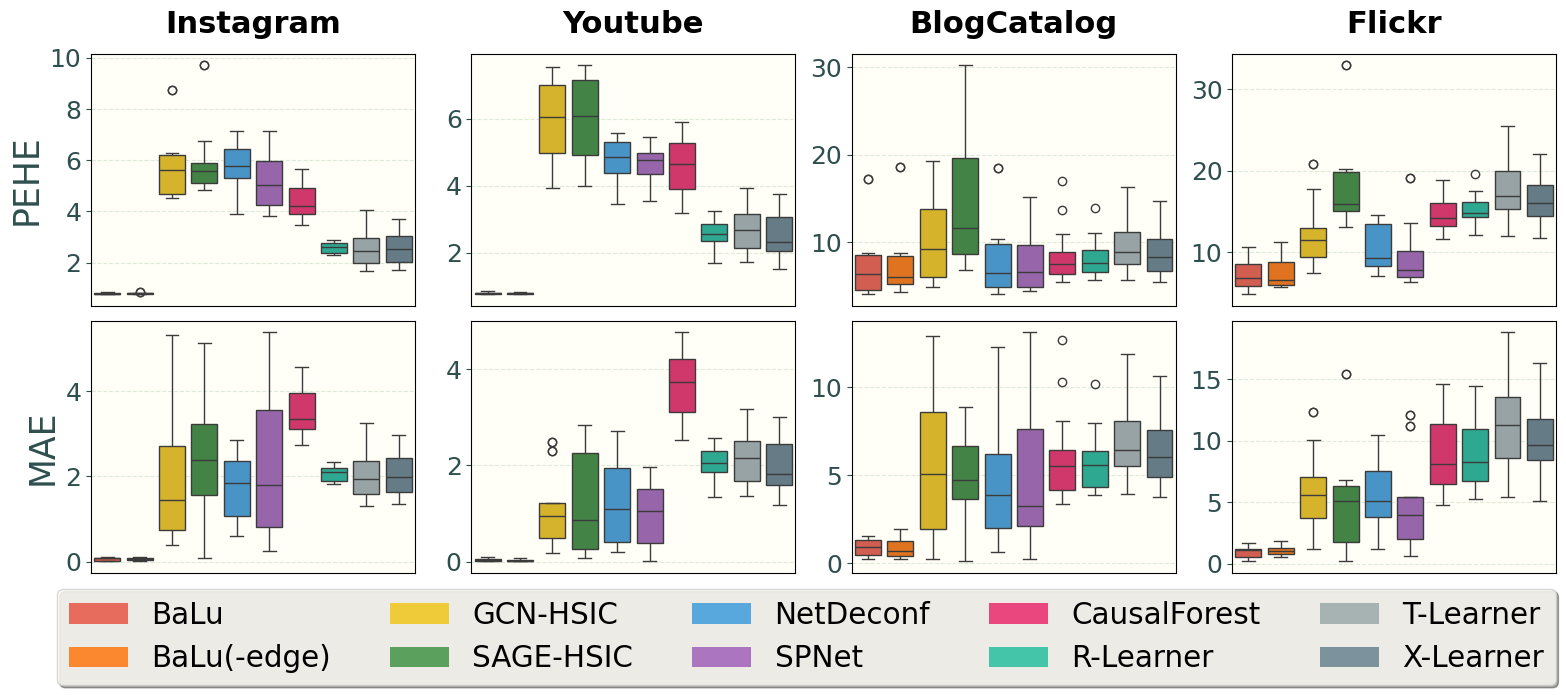

In [3]:

# from util import *
import pandas as pd

datasets = ['Syn_M=None_SimRel=1_Rel=4', 'Youtube_M=20_SimRel=1_Rel=4', 'BlogCatalog1_M=20_SimRel=0_Rel=1', 'Flickr1_M=20_SimRel=0_Rel=1']     # , 'BlogCatalog1_M=20_SimRel=1_Rel=4', 'Flickr1_M=20_SimRel=1_Rel=4'
datasets = [e+"_MCAR" for e in datasets] 
alian_names = ['Instagram', "Youtube", "BlogCatalog", "Flickr"]
dataset_map = {datasets[i]: alian_names[i] for i in range(len(datasets))}

p = '0.0'

balu_dir = 'results_balu_tuning'
df_balu = collect_data_p_balu(result_dir=balu_dir, p=p, datasets=datasets, train_test_flag='test')
# df_balu = df_balu.loc[df_balu['Method'] == 'Balu_V5']
df_balu['Method'] = df_balu['Method'].apply(lambda x: "BaLu(-edge)" if "IGMC" in str(x) else "BaLu")


other_dir = 'results_Q1_MAR_MCAR'
df_others = collect_data_p_others(result_dir=other_dir,p=p, datasets=datasets, train_test_flag='test')
df_others = df_others.loc[(df_others['Method'] != 'dml')]
df_others['Method'] = df_others['Method'].apply(lambda x: "GCN-HSIC" if "GCN" in str(x) else "SAGE-HSIC" if "GraphSAGE" in str(x) else x)
df_others['Method'] = df_others['Method'].apply(lambda x: "X-Learner" if str(x)=='xl' else "CausalForest" if str(x)=='cf' else "T-Learner" if 'tl' == str(x) else "R-Learner" if 'rl' == str(x) else x)

####################################################### Merge Dataframes, Oder rows #######################################################
result_df = pd.concat([df_balu, df_others], ignore_index=True)
result_df['Dataset'] = result_df['Dataset'].apply(lambda x: dataset_map[str(x)])
Methods_order = ['BaLu', 'BaLu(-edge)', 'GCN-HSIC', 'SAGE-HSIC', 'NetDeconf', 'SPNet', 'CausalForest', 'R-Learner', 'T-Learner', 'X-Learner']
result_df['Method'] = pd.Categorical(result_df['Method'], categories=Methods_order, ordered=True)
result_df_ordered = result_df.sort_values('Method')
result_df = result_df_ordered.reset_index(drop=True)


print(result_df['Method'].unique().tolist())
# display_dataframe_info(result_df)

create_grouped_boxplot(result_df, save_fn='figs/data_complete_results.pdf')